In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
from scipy.interpolate import RectBivariateSpline
import numpy as np

In [3]:
from vaneska.interpolate import ScipyRectBivariateSpline

In [4]:
import tensorflow as tf

In [5]:
from vaneska.models import KeplerPRF

In [6]:
prf = KeplerPRF(channel=56, shape=[10, 10], column=23, row=100)

In [38]:
flux = tf.Variable([1000.], dtype=tf.float64)
xc = tf.Variable([30.], dtype=tf.float64)
yc = tf.Variable([105.], dtype=tf.float64)

In [39]:
model = prf(flux, xc, yc)

In [50]:
grad = tf.gradients(model, [xc])

In [51]:
grad

[<tf.Tensor 'gradients_3/sub_15_grad/Reshape_1:0' shape=(1,) dtype=float64>]

In [52]:
sess = tf.Session()

In [53]:
sess.run(tf.global_variables_initializer())

In [54]:
sess.run(grad)

InvalidArgumentError: Input to reshape is a tensor with 10 values, but the requested shape has 1
	 [[Node: gradients_3/sub_15_grad/Reshape_1 = Reshape[T=DT_DOUBLE, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](gradients_3/sub_15_grad/Neg, gradients_3/mul_7_grad/Shape)]]

Caused by op 'gradients_3/sub_15_grad/Reshape_1', defined at:
  File "/Users/jvmirca/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jvmirca/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-b8ab20d19212>", line 1, in <module>
    grad = tf.gradients(model, [xc])
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 611, in gradients
    lambda: grad_fn(op, *out_grads))
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 377, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 611, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py", line 777, in _SubGrad
    array_ops.reshape(-math_ops.reduce_sum(grad, ry), sy))
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3903, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'sub_15', defined at:
  File "/Users/jvmirca/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-ba7db556dfef>", line 1, in <module>
    model = prf(flux, xc, yc)
  File "/Users/jvmirca/dev/vaneska/vaneska/models.py", line 96, in __call__
    return self.evaluate(flux, xc, yc)
  File "/Users/jvmirca/dev/vaneska/vaneska/models.py", line 99, in evaluate
    dx = self.x - xc
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 934, in binary_op_wrapper
    return func(x, y, name=name)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4819, in _sub
    "Sub", x=x, y=y, name=name)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 10 values, but the requested shape has 1
	 [[Node: gradients_3/sub_15_grad/Reshape_1 = Reshape[T=DT_DOUBLE, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](gradients_3/sub_15_grad/Neg, gradients_3/mul_7_grad/Shape)]]


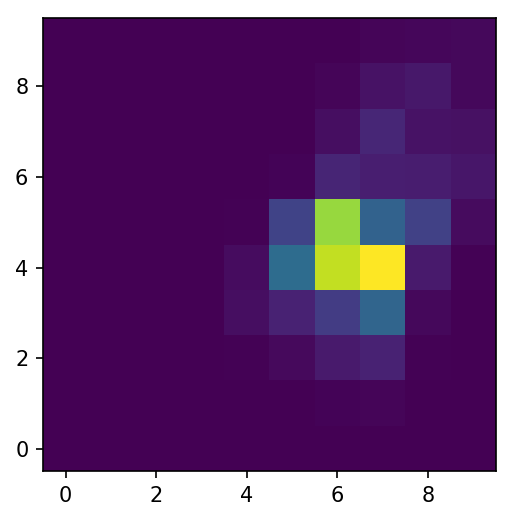

In [30]:
plt.imshow(sess.run(prf(flux, xc, yc)), origin='lower')

In [5]:
y, x = np.mgrid[0:10:100j, 0:10:100j]

In [6]:
z = x ** 2 + y ** 2

In [7]:
interp = RectBivariateSpline(x[0], y[:, 0], z)

In [8]:
xs = ys = np.linspace(0, 10, 10)

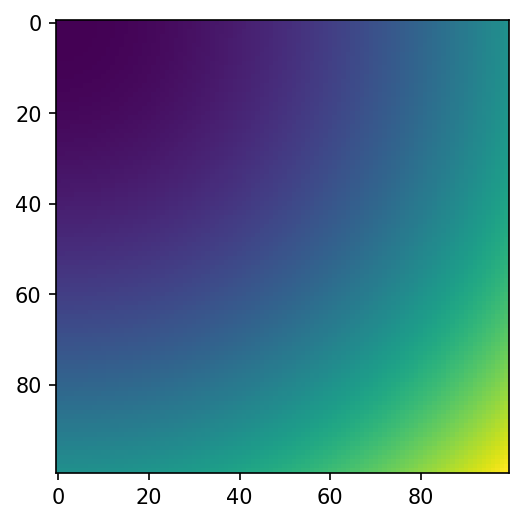

In [9]:
plt.imshow(z)

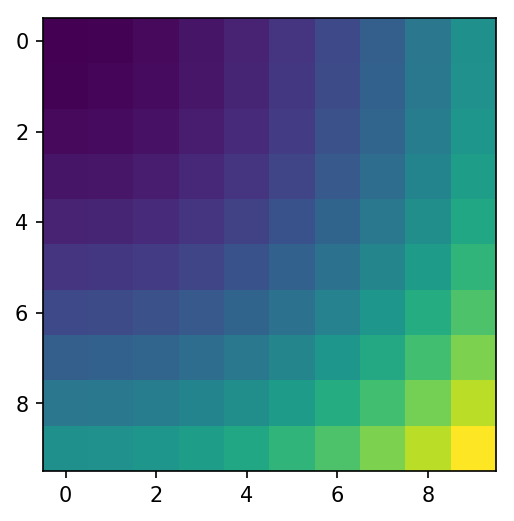

In [10]:
plt.imshow(interp(xs, ys))

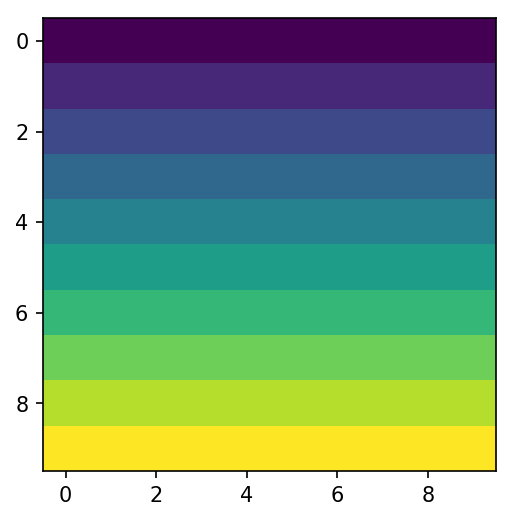

In [11]:
plt.imshow(interp(xs, ys, dx=1))

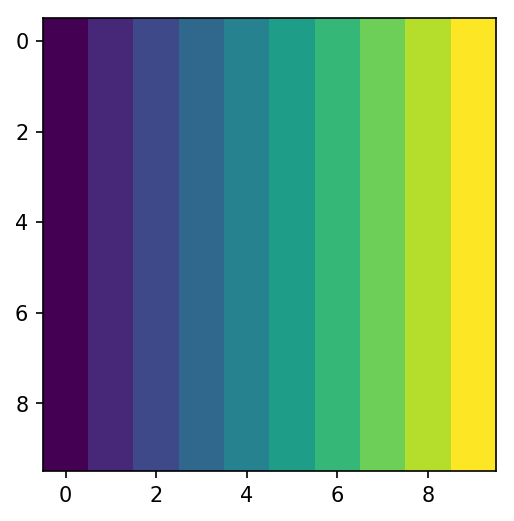

In [12]:
plt.imshow(interp(xs, ys, dy=1))

In [13]:
interp_tf = ScipyRectBivariateSpline(x[0], y[:, 0], z)

In [14]:
xs_t = tf.constant(xs, dtype=tf.float64)
ys_t = tf.constant(ys, dtype=tf.float64)

In [15]:
sess = tf.Session()

In [18]:
sess.run(interp_tf(xs_t, ys_t))

(10,)

In [19]:
z_t = interp_tf(xs_t, ys_t)

In [23]:
y = tf.Variable([1])
x = tf.Variable([2])
z = x * y

In [31]:
sess.run(tf.global_variables_initializer())
sess.run(tf.gradients(z, [x]))

[array([1], dtype=int32)]

In [32]:
sess.run(tf.gradients(z_t, [xs_t]))

[array([[  9.23309735e-17,  -1.64868119e-15,   4.39648318e-15,
           7.47402140e-14,  -6.15507645e-14,  -1.14308563e-13,
           4.39648318e-13,   1.05515596e-13,  -9.49640366e-13,
           0.00000000e+00],
        [  2.22222222e+00,   2.22222222e+00,   2.22222222e+00,
           2.22222222e+00,   2.22222222e+00,   2.22222222e+00,
           2.22222222e+00,   2.22222222e+00,   2.22222222e+00,
           2.22222222e+00],
        [  4.44444444e+00,   4.44444444e+00,   4.44444444e+00,
           4.44444444e+00,   4.44444444e+00,   4.44444444e+00,
           4.44444444e+00,   4.44444444e+00,   4.44444444e+00,
           4.44444444e+00],
        [  6.66666667e+00,   6.66666667e+00,   6.66666667e+00,
           6.66666667e+00,   6.66666667e+00,   6.66666667e+00,
           6.66666667e+00,   6.66666667e+00,   6.66666667e+00,
           6.66666667e+00],
        [  8.88888889e+00,   8.88888889e+00,   8.88888889e+00,
           8.88888889e+00,   8.88888889e+00,   8.88888889e+00,
      

In [22]:
sess.run(tf.gradients(z_t, [ys_t]))

[array([[ -7.94809630e-16,   2.22222222e+00,   4.44444444e+00,
           6.66666667e+00,   8.88888889e+00,   1.11111111e+01,
           1.33333333e+01,   1.55555556e+01,   1.77777778e+01,
           2.00000000e+01],
        [ -1.20903287e-14,   2.22222222e+00,   4.44444444e+00,
           6.66666667e+00,   8.88888889e+00,   1.11111111e+01,
           1.33333333e+01,   1.55555556e+01,   1.77777778e+01,
           2.00000000e+01],
        [  4.83613150e-14,   2.22222222e+00,   4.44444444e+00,
           6.66666667e+00,   8.88888889e+00,   1.11111111e+01,
           1.33333333e+01,   1.55555556e+01,   1.77777778e+01,
           2.00000000e+01],
        [  3.07753822e-14,   2.22222222e+00,   4.44444444e+00,
           6.66666667e+00,   8.88888889e+00,   1.11111111e+01,
           1.33333333e+01,   1.55555556e+01,   1.77777778e+01,
           2.00000000e+01],
        [ -1.67066361e-13,   2.22222222e+00,   4.44444444e+00,
           6.66666667e+00,   8.88888889e+00,   1.11111111e+01,
      

TypeError: Invalid dimensions for image data

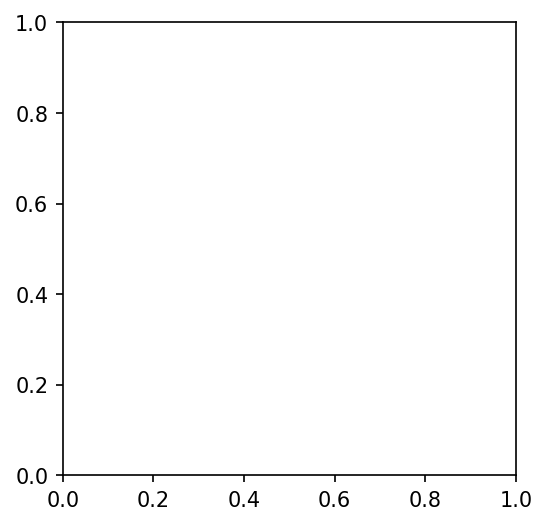

In [30]:
plt.imshow(sess.run(tf.gradients(z_t, [xs_t])))

In [40]:
sess.run(tf.gradients(z_t, [xs_t]))

[array([[  9.23309735e-17,  -1.64868119e-15,   4.39648318e-15,
           7.47402140e-14,  -6.15507645e-14,  -1.14308563e-13,
           4.39648318e-13,   1.05515596e-13,  -9.49640366e-13,
           0.00000000e+00],
        [  2.22222222e+00,   2.22222222e+00,   2.22222222e+00,
           2.22222222e+00,   2.22222222e+00,   2.22222222e+00,
           2.22222222e+00,   2.22222222e+00,   2.22222222e+00,
           2.22222222e+00],
        [  4.44444444e+00,   4.44444444e+00,   4.44444444e+00,
           4.44444444e+00,   4.44444444e+00,   4.44444444e+00,
           4.44444444e+00,   4.44444444e+00,   4.44444444e+00,
           4.44444444e+00],
        [  6.66666667e+00,   6.66666667e+00,   6.66666667e+00,
           6.66666667e+00,   6.66666667e+00,   6.66666667e+00,
           6.66666667e+00,   6.66666667e+00,   6.66666667e+00,
           6.66666667e+00],
        [  8.88888889e+00,   8.88888889e+00,   8.88888889e+00,
           8.88888889e+00,   8.88888889e+00,   8.88888889e+00,
      

In [39]:
tf.gradients(z_t, [xs_t])

[<tf.Tensor 'gradients_15/Interpolate_1_grad/PyFunc:0' shape=(10,) dtype=float64>]